<a href="https://colab.research.google.com/github/jelade/deep-learning/blob/main/Foundations_of_Deep_learning%2C_CNNs_JALEEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Convolutional networks
In this tutorial, you will implement a simple convolutional neural network (CNN) with pytorch to classifiy images of handwritten digits.

**Make sure you are setting the runtime to GPU**


This tutorial is based on convnet turorials from AMMI computer vision course 2021

In [1]:
import random

import PIL
import imageio
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms
from IPython import display

Useful methods for visualization

In [2]:
%matplotlib inline

def show(img):
    """Show PyTorch tensor img as an image in matplotlib."""
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.grid(False)
    plt.gca().axis('off')

def display_thumb(img):
  display.display(transforms.Resize(128)(img))

In [3]:
# Use GPU if available 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Load the training and test dataset.
mnist_train = datasets.MNIST('/tmp/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('/tmp/mnist', train=False, download=True, transform=transforms.ToTensor())

# Size of the batches the data loader will produce.
batch_size = 64

# This creates the dataloaders.
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 126465657.12it/s]


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 104157948.26it/s]


Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42531849.55it/s]


Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6633192.47it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



Image label:5


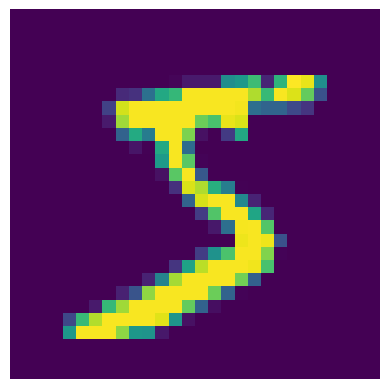

In [5]:
img, label = next(iter(mnist_train))
print(f"Image label:{label}")
show(img)

In [7]:
img.size()

torch.Size([1, 28, 28])

In [6]:
# Training Function 
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model.""" 
    
    # Make sure model is in training mode.
    model.train()
    
    # Move model to the device (CPU or GPU).
    model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None
    
    # Loop over epochs.
    for epoch in range(num_epochs):
        
      # Loop over data.
      for batch_idx, (data, target) in enumerate(data_loader):
            
          # Forward pass.
          output = model(data.to(device))
          loss = criterion(output.to(device), target.to(device))
          
          # Backward pass.
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # NOTE: It is important to call .item() on the loss before summing.
          if ema_loss is None:
            ema_loss = loss.item()
          else:
            ema_loss += (loss.item() - ema_loss) * 0.01 
          
      # Print out progress the end of epoch.
      print('Train Epoch: {} \tLoss: {:.6f}'.format(
            epoch, ema_loss),
      )
              
# Testing Function               
def test(model, data_loader):
    """Measures the accuracy of a model on a data set.""" 
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0

    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
        
        # Loop over test data.
        for data, target in data_loader:
          
            # Forward pass.
            output = model(data.to(device))
            
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)
            
            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100. * correct / len(data_loader.dataset)
    print(f'Accuracy: {correct} / {len(data_loader.dataset)} ({percent:.0f}%)')
    return percent
   

## ConvNet Model

In [29]:
from torch.nn.modules.activation import ReLU
class ConvolutionalNetwork(nn.Module):
  """Simple convolutional network."""
  
  def __init__(self, image_side_size, num_classes, in_channels=1):
      super(ConvolutionalNetwork, self).__init__()
      
      self.in_channels = in_channels
      self.num_classes = num_classes
      self.image_side_size = image_side_size
      # Fill these in:
      ##########################################################################
      # TODO: Implement a convulutional and a linear part.                     #
      # Hint: see forward() to understand how they should work together.       #
      # Hint: use the method get_conv_network_output to get the size of the input to the linear part
      ##########################################################################       

      # Define the convolution part, self.conv_network, you can use parameters in the slides as a starting point
      # Get the output size from the convolution part using the method get_conv_network_output
      # Define the linear part, self.linear
      self.conv_network = nn.Sequential(
          nn.Conv2d(in_channels = self.in_channels,out_channels = 16,  kernel_size = 5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride = 2),
          nn.Conv2d(in_channels = 16,out_channels = 32,  kernel_size = 5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride = 2)
      )

  
      

      self.mlp = nn.Sequential(
          nn.Linear(self.get_conv_network_output(), 64),
          nn.ReLU(),
          nn.Linear(64, self.num_classes),
          nn.ReLU()
      )
  def forward(self, x):
      x = self.conv_network(x)
      x = self.mlp(x.view(x.size(0), -1))
      return x

  def get_conv_network_output(self, ):
      dummy_x = torch.zeros(1, self.in_channels, self.image_side_size, self.image_side_size)
      conv_output = self.conv_network(dummy_x)
      conv_output_size = torch.prod(torch.tensor(conv_output.shape))
      return conv_output_size

    
# Create and train convolutional network.
# The accuracy should be around 96%.

###########################################################################
# TODO: Create criterion and optimize here.                               #
###########################################################################
model = ConvolutionalNetwork(image_side_size = 28, num_classes = 10, in_channels=1)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
###########################################################################
# TODO: Train the model and test it on the test set
###########################################################################
train(model, criterion, train_loader, optimizer, num_epochs)

Train Epoch: 0 	Loss: 46.846282
Train Epoch: 1 	Loss: 45.239664
Train Epoch: 2 	Loss: 45.090048
Train Epoch: 3 	Loss: 43.400771
Train Epoch: 4 	Loss: 43.832156
Train Epoch: 5 	Loss: 43.514535
Train Epoch: 6 	Loss: 43.530369
Train Epoch: 7 	Loss: 43.820365
Train Epoch: 8 	Loss: 43.038723
Train Epoch: 9 	Loss: 43.435490


In [30]:
# Print the testing accuracy it should be around 96%

test(model, test_loader)

Accuracy: 8000 / 10000 (80%)


80.0